### Importing necessary libraries

In [ ]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Creating a GPU device if available

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Creating the dataset and loading in the monkeys

In [ ]:
composed = transforms.Compose([
    # transforms.Grayscale(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([256, 256])  # Square images idea for CNN

])

class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = 0

        # Adding all monkeys to a list
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.number_samples += 1
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        # Read monkey image from directory name
        monkey = read_image(monkey_path)

        # Get monkey label from filename
        label = monkey_filename[:2]  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms:
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        # This will allow len()
        return self.number_samples



# train_data = MonkeyDataset()
training_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)
validation_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/validation/validation",
    transform = composed
)

### Testing dataloaders and showing example monkey

tensor([[[0.6471, 0.6510, 0.6510,  ..., 0.9143, 0.6465, 0.3889],
         [0.6471, 0.6510, 0.6497,  ..., 0.8984, 0.4545, 0.2377],
         [0.6510, 0.6510, 0.6497,  ..., 0.6142, 0.2894, 0.1669],
         ...,
         [0.3559, 0.3859, 0.3941,  ..., 0.5661, 0.4663, 0.3894],
         [0.3591, 0.3770, 0.3851,  ..., 0.4795, 0.4150, 0.3712],
         [0.3481, 0.3665, 0.3658,  ..., 0.4312, 0.3973, 0.3622]],

        [[0.9529, 0.9569, 0.9569,  ..., 0.8944, 0.6024, 0.3264],
         [0.9529, 0.9569, 0.9555,  ..., 0.8546, 0.3959, 0.1759],
         [0.9569, 0.9569, 0.9555,  ..., 0.5402, 0.2226, 0.1166],
         ...,
         [0.3005, 0.3166, 0.3163,  ..., 0.6633, 0.5771, 0.5017],
         [0.3020, 0.3196, 0.3199,  ..., 0.6015, 0.5271, 0.4727],
         [0.2993, 0.3193, 0.3148,  ..., 0.5550, 0.5122, 0.4634]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8431, 0.4372, 0.1920],
         [1.0000, 1.0000, 1.0000,  ..., 0.7364, 0.2229, 0.0823],
         [1.0000, 1.0000, 1.0000,  ..., 0.3629, 0.0939, 0.

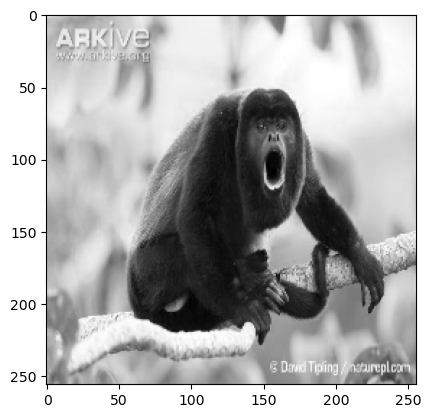

In [103]:
# dataloaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

# iterating through the dataloader
train_features, train_labels = next(iter(train_dataloader))
print(train_features[0], train_labels)
plt.imshow(train_features[63][0], cmap="gray")
plt.show()

In [ ]:
e = pd.read_csv("./kaggle/input/10-monkey-species/monkey_labels.txt")
e.iloc[:,3]